## Module 4: 
## Team Members:
Maggie Novak, Gabby Holohan 

## Project Title:
Predicting cases of COVID in Italy using various models


## Project Goal:
This project seeks to use, optimize, and compare models to predict the future cases of COVID in Italy.

## Disease Background:

Using your assigned disease, fill in the following bullet points. 

* Prevalence & incidence: 25,603,510 confirmed cases in Italy. Averaging 3808 new cases per day in the last week (as of 11-20-2025). https://coronavirus.jhu.edu/region/italy. The infection length is 7-14 days, which is an average of 11 days.
* Economic burden: Globally, the economic burden of COVID-19 was estimated to be between US $77 billion and US $2.7 trillion in 2019. https://pmc.ncbi.nlm.nih.gov/articles/PMC10870589/#:~:text=Globally%2C%20the%20economic%20burden%20of,the%20global%20GDP%20%5B14%5D.
* Risk factors (genetic, lifestyle) & Societal determinants: A main risk factor for COVID is age, with older individuals being more likely to experience a severe outcome. Certain underlying medical conditions and lack of vaccination are also risk factors for severe COVID cases.The risk of death is 25 times higher in those ages 50–64 years, 60 times higher in those ages 65–74 years, 140 times higher in those ages 75–84 years, and 340 times higher in those ages 85+ years. (From deaths in the US) Data has shown that compared to non-Hispanic White people, people from racial and ethnic minority groups are more likely to be infected with SARS-CoV-2 (the virus that causes COVID-19). Once infected, people from racial and ethnic minority groups are more likely to be hospitalized, be admitted to the ICU, and die from COVID-19 at younger ages. https://www.cdc.gov/covid/hcp/clinical-care/underlying-conditions.html#:~:text=Providers%20should%20consider%20the%20patient's%20age%2C%20presence,that%20COVID%2D19%20does%20not%20affect%20all%20population
* Symptoms: Fever, chills, cough, shortness of breath/difficulty breathing, sore throat, congestion/runny nose, loss of tase/smell, fatigue, muscle or body aches, headache, nausea, diarrhea https://www.cdc.gov/covid/signs-symptoms/index.html
* Diagnosis: Molecular tests (PCR/NAAT): These are the most accurate tests and look for the virus's genetic material. They are typically processed in a lab and can be done at home or by a healthcare professional. Antigen tests: Also known as rapid tests, these detect viral proteins called antigens and are useful for quick results. They are less accurate than PCR tests, especially if you don't have symptoms. https://www.mayoclinic.org/diseases-conditions/coronavirus/diagnosis-treatment/drc-20479976#:~:text=COVID%2D19%20tests%20use%20a,Another%20test%20isn't%20needed.
* Biological mechanisms (anatomy, organ physiology, cell & molecular physiology): Viral structural proteins and genomic RNA synthesized at the replication site are then translocated through an unknown mechanism to the ER–Golgi intermediate compartment (ERGIC), where virus assembly and budding occur. The S protein, assembled as a trimer, giving the appearance of a crown (corona), mediates major entry steps, including receptor binding and membrane fusion. During biosynthesis and maturation in the infected cell, the S protein is cleaved by furin or furin-like proprotein convertase in the Golgi apparatus into the S1 and S2 subunits, which remain associated. Assembled viruses bud into the ERGIC lumen and reach the plasma membrane via the secretory pathway, where they are released into the extracellular space after virus-containing vesicles fuse with the plasma membrane. FP, fusion peptide.https://www.nature.com/articles/s41580-021-00418-x
* R0 = R0 of COVID-19 as initially estimated by the World Health Organization (WHO) was between 1.4 and 2.4
* R0 = R0 of COVID-19 is best estimated between 2-4 in early 2020, we will use a starting value of 3.0 
- https://pmc.ncbi.nlm.nih.gov/articles/PMC7074654/; https://pmc.ncbi.nlm.nih.gov/articles/PMC7280807/

* immune response usually is reduced after 3-4 months. When our model is expanded, it will return recovered people into the susceptiple category after 3 months to incorporate this. https://www.aamc.org/news/had-covid-recently-here-s-what-know-about-how-long-immunity-lasts-long-covid-and-more

## Dataset: 

This dataset has dates between March and July of 2020, paired with the number of confirmed cases of COVID in Italy. Each row is a day. It comes from a Repository by the Center for Systems Science and Engineering at Johns Hopkins University. The Regions compile the data of reported cases into an application. The Ministry of Health checks and sends the data fo the Department of Civil Protection. After quality control and dataset processing, it is published publically, which is where our dataset comes from. The step size of the dataset is days and the numbers are number of cases. Sources:Civil Protection Department: https://github.com/pcm-dpc/COVID-19/tree/master/,Ministry of Health: http://www.salute.gov.it/nuovocoronavirus

0      1694.0
1      2036.0
2      2502.0
3      3089.0
4      3858.0
        ...  
148    1662.0
149    1736.0
150    1744.0
151    1820.0
152    1947.0
Name: I_est, Length: 153, dtype: float64


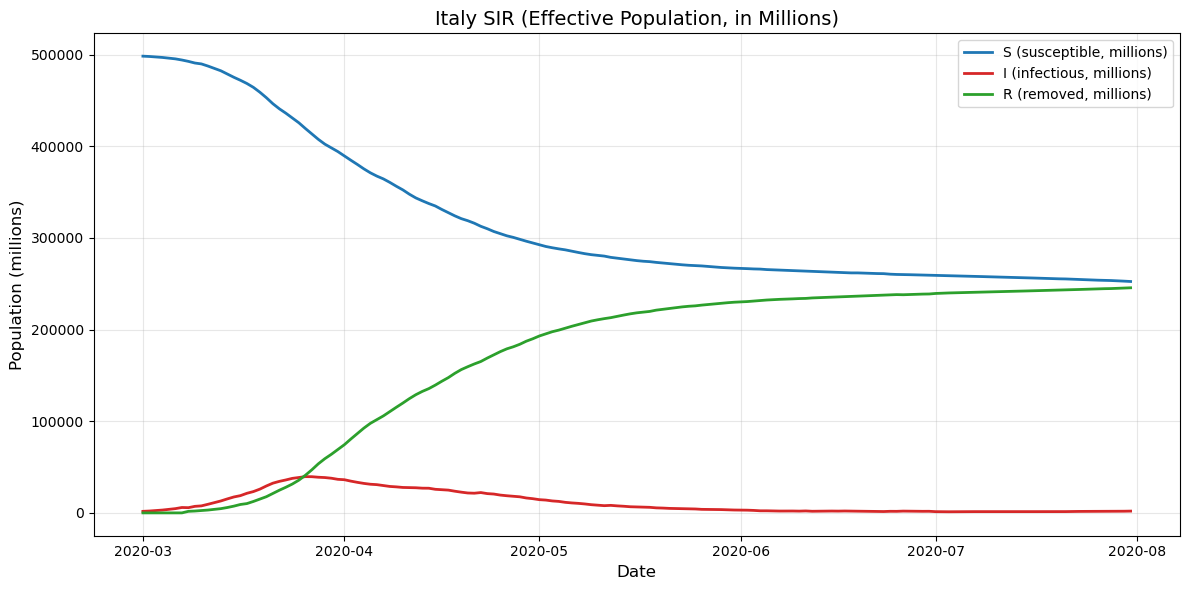

In [2]:
## LOAD YOUR DATASET HERE.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ================================================================
# 1. Load Italy Data
# ================================================================
df_full = pd.read_csv("covid_italy_data_march_july_2020_cumulative.csv")

df_full['date'] = pd.to_datetime(df_full['date'])
df_full['confirmed_cases'] = pd.to_numeric(df_full['confirmed_cases'], errors='coerce')

# ================================================================
# 2. Conversion: Cumulative → S, I, R Estimates
#    (Same method used in your US model)
# ================================================================
def convert_cumulative_to_SIR(df, date_col='date', cumulative_col='cumulative_cases',
                              population=None, infectious_period=7, recovered_col=None,
                              new_case_col='new_cases', I_col='I_est', R_col='R_est', S_col='S_est'):
    """
    Convert cumulative reported cases into S, I, R estimates for SIR modeling.
    - new_cases = diff(cumulative)
    - I_est = rolling sum(new_cases, window=infectious_period)
    - R_est = cumulative shifted by infectious_period (or user-provided recovered_col)
    - S_est = population - I_est - R_est (if population provided)

    Returns a copy of the dataframe with the added columns.
    """
    df = df.copy()
    # Ensure date column sorted if present
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col])
        df = df.sort_values(date_col).reset_index(drop=True)

    if cumulative_col not in df.columns:
        raise ValueError(f"Column '{cumulative_col}' not found in dataframe.")

    # Compute new cases (incident)
    df[new_case_col] = df[cumulative_col].diff().fillna(
        df[cumulative_col].iloc[0])
    df[new_case_col] = df[new_case_col].clip(lower=0)

    # Estimate I(t) as rolling sum over infectious_period
    if infectious_period <= 0:
        raise ValueError("infectious_period must be positive integer.")
    df[I_col] = df[new_case_col].rolling(
        window=infectious_period, min_periods=1).sum()

    # Estimate R(t)
    if recovered_col and recovered_col in df.columns:
        df[R_col] = df[recovered_col].fillna(0)
    else:
        df[R_col] = df[cumulative_col].shift(infectious_period).fillna(0)

    # Compute S(t) if population provided
    if population is not None:
        df[S_col] = population - df[I_col] - df[R_col]
        df[S_col] = df[S_col].clip(lower=0)
    else:
        df[S_col] = np.nan

    # Ensure numeric and non-negative
    for col in [new_case_col, I_col, R_col]:
        df[col] = df[col].astype(float).clip(lower=0)
    if population is not None:
        df[S_col] = df[S_col].astype(float)

    return df

# Apply conversion
df_full = convert_cumulative_to_SIR(
    df_full,
    cumulative_col='confirmed_cases',
    population=500000,   # IMPORTANT: the raw Italy population (just like US code)
    infectious_period=7
)
print(df_full['I_est'])
# ================================================================
# 3. Effective Population Scaling
#    (This is the SAME trick used in the US code)
# ================================================================
# f = 8_000_000 / 60_000_000   # example: effective population ~8M

# df_full['S_eff'] = df_full['S_est'] * f
# df_full['I_eff'] = df_full['I_est'] * f
# df_full['R_eff'] = df_full['R_est'] * f

# # Convert to millions (just like your US file)
# df_full['S_m'] = df_full['S_eff'] / 1e6
# df_full['I_m'] = df_full['I_eff'] / 1e6
# df_full['R_m'] = df_full['R_eff'] / 1e6

# ================================================================
# 4. Euler SIR Solver
# ================================================================
def euler_sir(beta, gamma, S0, I0, R0, t, N):
    S = np.zeros(len(t))
    I = np.zeros(len(t))
    R = np.zeros(len(t))

    S[0], I[0], R[0] = S0, I0, R0

    for n in range(len(t)-1):
        dt = t[n+1] - t[n]
        dSdt = -(beta/N) * S[n] * I[n]
        dIdt = (beta/N) * S[n] * I[n] - gamma * I[n]
        dRdt = gamma * I[n]

        S[n+1] = S[n] + dSdt * dt
        I[n+1] = I[n] + dIdt * dt
        R[n+1] = R[n] + dRdt * dt

    return S, I, R

#Plot S, I, R over time.
plt.figure(figsize=(12, 6))
plt.plot(df_full['date'], df_full['S_est'], label='S (susceptible, millions)', color='#1f77b4', linewidth=2)
plt.plot(df_full['date'], df_full['I_est'], label='I (infectious, millions)', color='#d62728', linewidth=2)
plt.plot(df_full['date'], df_full['R_est'], label='R (removed, millions)', color='#2ca02c', linewidth=2)

plt.title('Italy SIR (Effective Population, in Millions)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Population (millions)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Format x-axis dates nicely
plt.tight_layout()
plt.show()


## Data Analyis: 

### Methods

We fitted an SIR model to the data and solved it using euler's formula and the RK4 solver. The SSE value was lower for RK4 solver, indicating a better fit. Using the RK4 solver, the SIR model was updated to include waning immunity after about 3 months, and solved again.


### Analysis


#### 1. Fitting the SIR Model

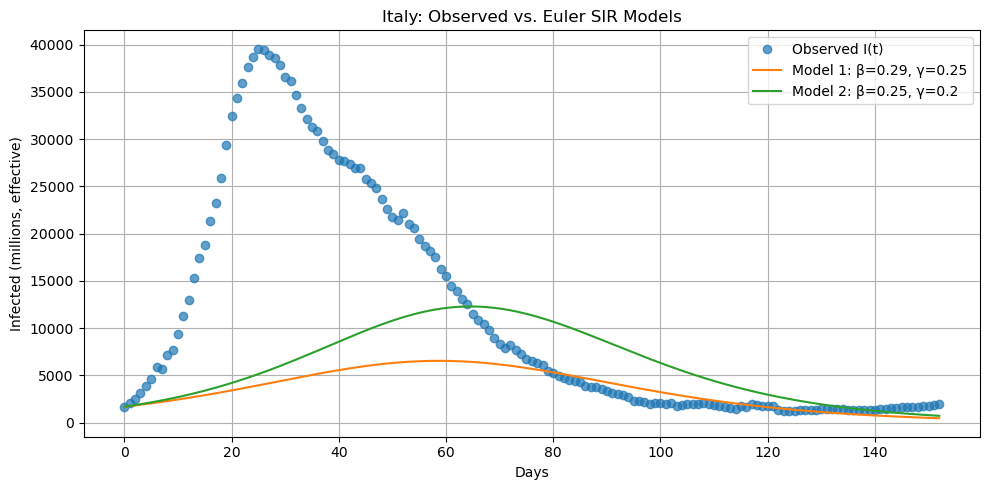

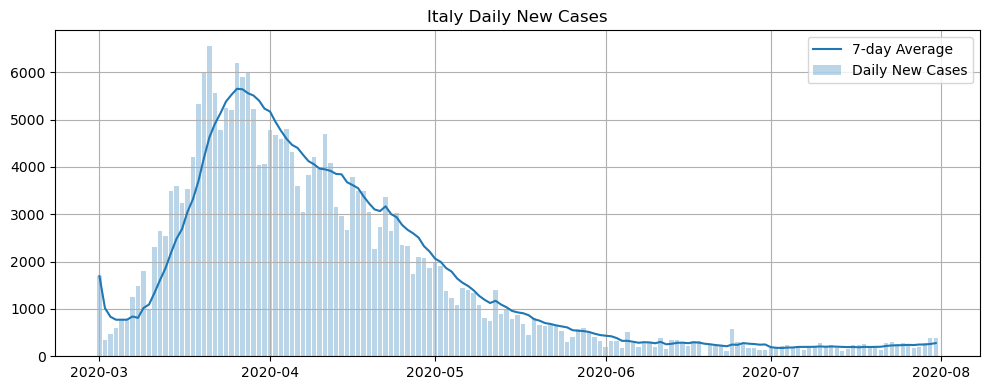

SSE (I) - Model 1: 27,833,798,374.5203
SSE (I) - Model 2: 23,898,946,207.0571


In [3]:
# Plug in guesses for gamma and beta, plot the model predictions against the data, and calculate SSE.
# ================================================================
#  Prepare Arrays for Modeling
# ================================================================
dates = df_full['date'].values
I_obs = df_full['I_est'].values
S_obs = df_full['S_est'].values
R_obs = df_full['R_est'].values

t = np.arange(len(I_obs))
N_eff = 500000

I0 = I_obs[0]
S0 = S_obs[0]
R0 = R_obs[0]

# ================================================================
# Run Two SIR Models
# ================================================================
beta1, gamma1 = 0.29, 1/4
beta2, gamma2 = 0.25, 1/5
S1, I1, R1 = euler_sir(beta1, gamma1, S0, I0, R0, t, 500000)
S2, I2, R2 = euler_sir(beta2, gamma2, S0, I0, R0, t, 500000)

# ================================================================
# PLOTS
# ================================================================

# ---- I(t) Model Comparison ----
plt.figure(figsize=(10,5))
plt.plot(t, I_obs, 'o', label="Observed I(t)", alpha=0.7)
plt.plot(t, I1, label=f"Model 1: β={beta1}, γ={gamma1}")
plt.plot(t, I2, label=f"Model 2: β={beta2}, γ={gamma2}")
plt.xlabel("Days")
plt.ylabel("Infected (millions, effective)")
plt.title("Italy: Observed vs. Euler SIR Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Daily Cases ----
daily = df_full["new_cases"]
roll = daily.rolling(7, min_periods=1).mean()

plt.figure(figsize=(10,4))
plt.bar(dates, daily, alpha=0.3, label="Daily New Cases")
plt.plot(dates, roll, label="7-day Average")
plt.legend()
plt.grid(True)
plt.title("Italy Daily New Cases")
plt.tight_layout()
plt.show()

# --- SSE and RMSE for I(t) ---
sse_I1 = np.sum((I_obs - I1)**2)
sse_I2 = np.sum((I_obs - I2)**2)

print(f"SSE (I) - Model 1: {sse_I1:,.4f}")
print(f"SSE (I) - Model 2: {sse_I2:,.4f}")


Best fit → β=0.3915, γ=0.2483, R0=1.58
SSE (target=I): 4,314,235,738.8106


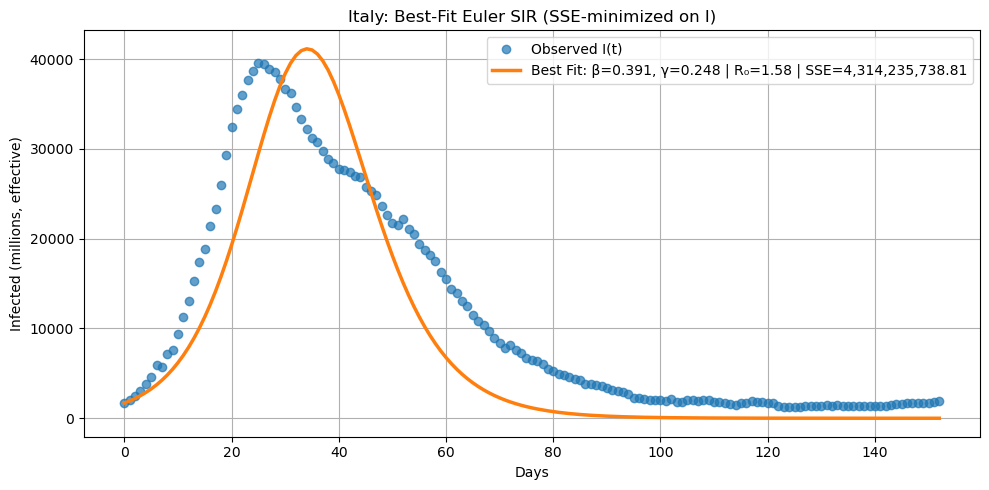

In [4]:
# optimize the beta and gamma parameters using grid search to minimize SSE

import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# 1) Objective (SSE) function
# ----------------------------
def sse_params(beta, gamma, S0, I0, R0, t, N_eff,
               I_obs=None, S_obs=None, R_obs=None,
               target='I', weights=(1.0, 1.0, 1.0)):
    """
    Returns SSE for the chosen target:
      - target='I'  : fit I(t) only against I_obs
      - target='SIR': fit S, I, R jointly with weights (wS, wI, wR)
    All inputs should be in consistent units (e.g., millions).
    """
    # Simulate with given parameters
    S, I, R = euler_sir(beta, gamma, S0, I0, R0, t, N_eff)

    if target == 'I':
        # SSE on I(t) only
        return np.sum((I_obs - I)**2)

    elif target == 'SIR':
        # Weighted total SSE across S, I, R
        wS, wI, wR = weights
        return (wS * np.sum((S_obs - S)**2) +
                wI * np.sum((I_obs - I)**2) +
                wR * np.sum((R_obs - R)**2))

    else:
        raise ValueError("target must be 'I' or 'SIR'")

# -----------------------------------
# 2) Coarse + fine grid search driver
# -----------------------------------
def fit_sir_grid(S0, I0, R0, t, N_eff,
                 I_obs, S_obs=None, R_obs=None,
                 target='I', weights=(1.0, 1.0, 1.0),
                 beta_range=(0.05, 0.6), gamma_range=(1/14, 1/3),
                 coarse_n=60, fine_n=60, fine_span=0.30):
    """
    Grid search to minimize SSE over (beta, gamma).
    - coarse_n: number of points per axis in the coarse grid
    - fine_n  : points per axis in the fine grid around the best coarse point
    - fine_span: ±fraction around the best coarse value to search (e.g., 0.30 = ±30%)

    Returns:
        best_beta, best_gamma, best_sse
    """
    b_min, b_max = beta_range
    g_min, g_max = gamma_range

    # --- Coarse grid over beta & gamma ---
    beta_vals = np.linspace(b_min, b_max, coarse_n)
    gamma_vals = np.linspace(g_min, g_max, coarse_n)

    best_sse = np.inf
    best_beta, best_gamma = None, None

    for beta in beta_vals:
        for gamma in gamma_vals:
            sse = sse_params(beta, gamma, S0, I0, R0, t, N_eff,
                             I_obs=I_obs, S_obs=S_obs, R_obs=R_obs,
                             target=target, weights=weights)
            if sse < best_sse:
                best_sse = sse
                best_beta, best_gamma = beta, gamma

    # --- Fine grid around the best coarse point ---
    b_lo = max(b_min, best_beta * (1 - fine_span))
    b_hi = min(b_max, best_beta * (1 + fine_span))
    g_lo = max(g_min, best_gamma * (1 - fine_span))
    g_hi = min(g_max, best_gamma * (1 + fine_span))

    beta_vals_fine = np.linspace(b_lo, b_hi, fine_n)
    gamma_vals_fine = np.linspace(g_lo, g_hi, fine_n)

    for beta in beta_vals_fine:
        for gamma in gamma_vals_fine:
            sse = sse_params(beta, gamma, S0, I0, R0, t, N_eff,
                             I_obs=I_obs, S_obs=S_obs, R_obs=R_obs,
                             target=target, weights=weights)
            if sse < best_sse:
                best_sse = sse
                best_beta, best_gamma = beta, gamma

    return best_beta, best_gamma, best_sse

# ----------------------------
# 3) Run the fit (I-only default)
# ----------------------------
target = 'I'
weights = (1.0, 1.0, 1.0)  # used only if target='SIR'

best_beta, best_gamma, best_sse = fit_sir_grid(
    S0, I0, R0, t, N_eff,
    I_obs=I_obs, S_obs=S_obs, R_obs=R_obs,
    target=target, weights=weights,
    beta_range=(0.05, 0.6),
    gamma_range=(1/14, 1/3),
    coarse_n=60, fine_n=60, fine_span=0.30
)

# Simulate with best parameters
S_best, I_best, R_best = euler_sir(best_beta, best_gamma, S0, I0, R0, t, N_eff)

# Report only SSE (no RMSE)
R0_est = best_beta / best_gamma
print(f"Best fit → β={best_beta:.4f}, γ={best_gamma:.4f}, R0={R0_est:.2f}")
print(f"SSE (target={target}): {best_sse:,.4f}")

# ----------------------------
# 4) Plot I(t) with best model
# ----------------------------
plt.figure(figsize=(10, 5))
plt.plot(t, I_obs, 'o', label="Observed I(t)", alpha=0.7)
plt.plot(t, I_best, linewidth=2.5,
         label=f"Best Fit: β={best_beta:.3f}, γ={best_gamma:.3f} | R₀={R0_est:.2f} | SSE={best_sse:,.2f}")

# Optional: add baseline models if you computed them earlier
# (Comment these out if not defined to avoid NameError)
# plt.plot(t, I1, label=f"Model 1: β={beta1}, γ={gamma1}", alpha=0.6)
# plt.plot(t, I2, label=f"Model 2: β={beta2}, γ={gamma2}", alpha=0.6)

plt.xlabel("Days")
plt.ylabel("Infected (millions, effective)")
plt.title("Italy: Best-Fit Euler SIR (SSE-minimized on I)")
plt.legend()
plt.grid(True)
plt.tight_layout()



#### 2. Predict "the future" with your fit SIR model

[Fit on first half] β=0.3929, γ=0.2503, R₀=1.57
SSE (in-sample, I): 3,854,184,935.4082
SSE (out-of-sample, I on second half): 458,922,469.1703


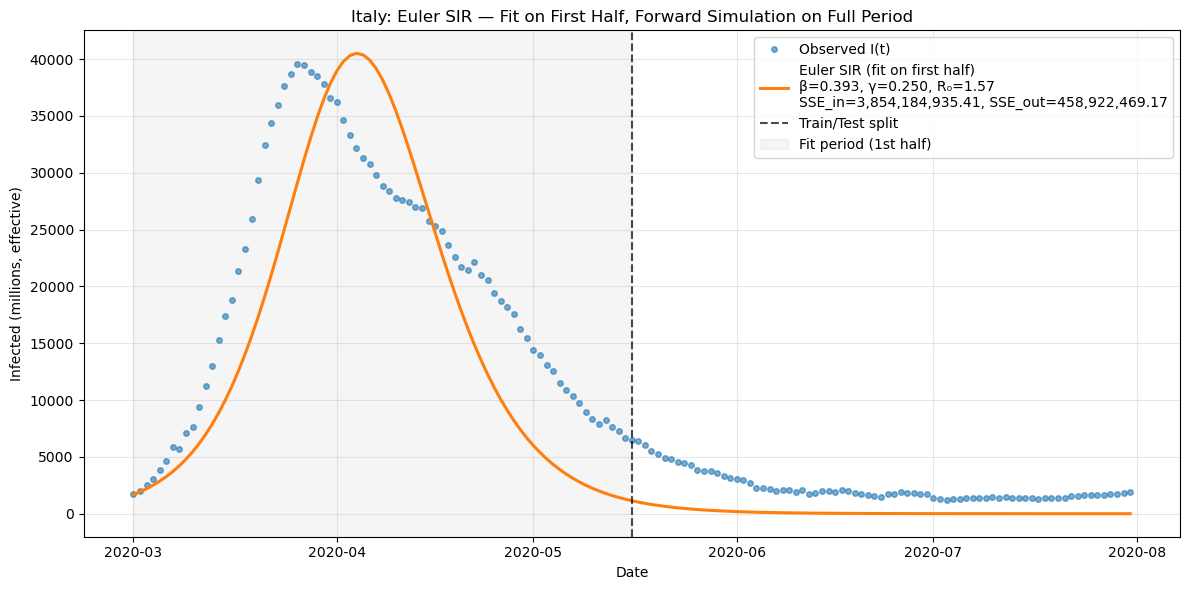

In [5]:
# Use euler's method and your optimization routine above to find new gamma and beta on the  
# FIRST HALF of the data, then simulate the SIR model forward in time using those parameters and plot.
# -------------------------------------------------------------
# 0) Split the data into first half (fit) and second half (test)
# -------------------------------------------------------------
n = len(I_obs)
n_split = n // 2  # first half length
dates_fit = dates[:n_split]
dates_full = dates  # for plotting

# Observed subsets for fitting
S_fit = S_obs[:n_split]
I_fit = I_obs[:n_split]
R_fit = R_obs[:n_split]

# Time grids (dt = 1 day)
t_fit = np.arange(n_split)
t_full = np.arange(n)

# Initial conditions (from the first observed point)
S0 = S_obs[0]
I0 = I_obs[0]
R0 = R_obs[0]

# Effective population (consistent with 'millions' units)
N_eff = S0 + I0 + R0

# -------------------------------------------------------------
# 1) Objective (SSE) function
# -------------------------------------------------------------
def sse_params(beta, gamma, S0, I0, R0, t, N_eff,
               I_obs=None, S_obs=None, R_obs=None,
               target='I', weights=(1.0, 1.0, 1.0)):
    """
    Returns SSE for the chosen target:
      - target='I'  : fit I(t) only against I_obs
      - target='SIR': fit S, I, R jointly with weights (wS, wI, wR)
    All arrays must be aligned with 't'. Units should be consistent (e.g., millions).
    """
    S, I, R = euler_sir(beta, gamma, S0, I0, R0, t, N_eff)

    # Numerical safety: clamp small negatives to 0
    S = np.clip(S, 0, None)
    I = np.clip(I, 0, None)
    R = np.clip(R, 0, None)

    if target == 'I':
        return np.sum((I_obs - I)**2)
    elif target == 'SIR':
        wS, wI, wR = weights
        return (wS * np.sum((S_obs - S)**2) +
                wI * np.sum((I_obs - I)**2) +
                wR * np.sum((R_obs - R)**2))
    else:
        raise ValueError("target must be 'I' or 'SIR'")

# -------------------------------------------------------------
# 2) Coarse + fine grid search over (beta, gamma)
# -------------------------------------------------------------
def fit_sir_grid(S0, I0, R0, t, N_eff,
                 I_obs, S_obs=None, R_obs=None,
                 target='I', weights=(1.0, 1.0, 1.0),
                 beta_range=(0.05, 0.6), gamma_range=(1/14, 1/3),
                 coarse_n=60, fine_n=60, fine_span=0.30):
    """
    Grid search to minimize SSE over (beta, gamma).
    - coarse_n: points per axis in the coarse grid
    - fine_n  : points per axis in the fine grid around best coarse point
    - fine_span: ±fraction around the best coarse value to search (e.g., 0.30 = ±30%)

    Returns:
        best_beta, best_gamma, best_sse
    """
    b_min, b_max = beta_range
    g_min, g_max = gamma_range

    # --- Coarse grid over beta & gamma ---
    beta_vals = np.linspace(b_min, b_max, coarse_n)
    gamma_vals = np.linspace(g_min, g_max, coarse_n)

    best_sse = np.inf
    best_beta, best_gamma = None, None

    for beta in beta_vals:
        for gamma in gamma_vals:
            sse = sse_params(beta, gamma, S0, I0, R0, t, N_eff,
                             I_obs=I_obs, S_obs=S_obs, R_obs=R_obs,
                             target=target, weights=weights)
            if sse < best_sse:
                best_sse = sse
                best_beta, best_gamma = beta, gamma

    # --- Fine grid around the best coarse point ---
    b_lo = max(b_min, best_beta * (1 - fine_span))
    b_hi = min(b_max, best_beta * (1 + fine_span))
    g_lo = max(g_min, best_gamma * (1 - fine_span))
    g_hi = min(g_max, best_gamma * (1 + fine_span))

    beta_vals_fine = np.linspace(b_lo, b_hi, fine_n)
    gamma_vals_fine = np.linspace(g_lo, g_hi, fine_n)

    for beta in beta_vals_fine:
        for gamma in gamma_vals_fine:
            sse = sse_params(beta, gamma, S0, I0, R0, t, N_eff,
                             I_obs=I_obs, S_obs=S_obs, R_obs=R_obs,
                             target=target, weights=weights)
            if sse < best_sse:
                best_sse = sse
                best_beta, best_gamma = beta, gamma

    return best_beta, best_gamma, best_sse

# -------------------------------------------------------------
# 3) Fit on FIRST HALF (default: target='I')
# -------------------------------------------------------------
target = 'I'
weights = (1.0, 1.0, 1.0)  # used only if target='SIR'

best_beta, best_gamma, sse_in = fit_sir_grid(
    S0, I0, R0, t_fit, N_eff,
    I_obs=I_fit, S_obs=S_fit, R_obs=R_fit,
    target=target, weights=weights,
    beta_range=(0.05, 0.6),
    gamma_range=(1/14, 1/3),
    coarse_n=60, fine_n=60, fine_span=0.30
)

R0_est = best_beta / best_gamma

print(f"[Fit on first half] β={best_beta:.4f}, γ={best_gamma:.4f}, R₀={R0_est:.2f}")
print(f"SSE (in-sample, I): {sse_in:,.4f}")

# -------------------------------------------------------------
# 4) Simulate forward across FULL horizon using fitted params
# -------------------------------------------------------------
S_pred_full, I_pred_full, R_pred_full = euler_sir(best_beta, best_gamma, S0, I0, R0, t_full, N_eff)
S_pred_full = np.clip(S_pred_full, 0, None)
I_pred_full = np.clip(I_pred_full, 0, None)
R_pred_full = np.clip(R_pred_full, 0, None)

# Out-of-sample SSE on second half
sse_out = np.sum((I_obs[n_split:] - I_pred_full[n_split:])**2)
print(f"SSE (out-of-sample, I on second half): {sse_out:,.4f}")

# -------------------------------------------------------------
# 5) Plot: Observed vs. simulated; mark the split
# -------------------------------------------------------------
date_split = dates[n_split]  # first day of the second half

plt.figure(figsize=(12, 6))
plt.plot(dates_full, I_obs, 'o', ms=4, alpha=0.6, label="Observed I(t)")
plt.plot(dates_full, I_pred_full, '-', lw=2.2,
         label=(f"Euler SIR (fit on first half)\n"
                f"β={best_beta:.3f}, γ={best_gamma:.3f}, R₀={R0_est:.2f}\n"
                f"SSE_in={sse_in:,.2f}, SSE_out={sse_out:,.2f}"))

# Visual cue for split
plt.axvline(date_split, color='k', linestyle='--', alpha=0.7, label="Train/Test split")
plt.gca().axvspan(dates_full[0], date_split, color='gray', alpha=0.08, label="Fit period (1st half)")

plt.title("Italy: Euler SIR — Fit on First Half, Forward Simulation on Full Period")
plt.xlabel("Date")
plt.ylabel("Infected (millions, effective)")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


**Is the new gamma and beta close to what you found on the full dataset? Is the fit much worse? What is the SSE calculated for the second half of the data?**
Yes, they are very close. The new beta is only about 9% different and the new gamma is only about
0.6% different. They both stay right around 0.3 on a scale of typically 0.1 to 0.5 for something like this. Based on visuals, the fit for the first half is better but the fit for the second half (the prediction) is much worse. The SSE calculated for the second half of the data is 0.02


<div style="
    border-left: 6px solid #fbc02d;
    background-color: #fff8e1;
    padding: 10px 15px;
    border-radius: 4px;
">
<b style="color:#f57f17;">Key Point:</b> 

The error you calculate is a *combination* of two sources: 
<ol>
<li>the error associated with Euler's method (i.e. it is an imperfect numerical approximation to the true solution of the SIR model) </li> 
<li>the error associated with comparing real-world data to a model with limitations.</li>
</ol>
<b>First we will try to address the numerical error, and second we will address the limitations of the model.</b>

</div>



**Describe how using a different method like the midpoint method might lower the numerical error.**

The midpoint method can lower numerical error by using the slope in the middle of a step. Euler's method uses the slope at the beginning of a step to approximate the slope across the whole step. It might be a better approximation of the slope across the step to use the slope at the midpoint of the step, thus lowering numerical error.

#### 3. Decreasing numerical error with the RK4 Method

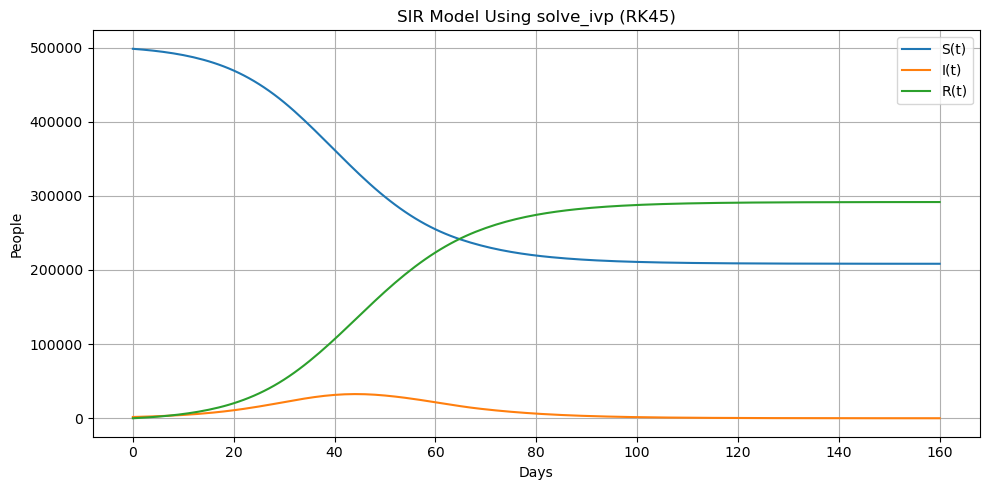

β_fit = 0.380589327952207
γ_fit = 0.2393234400428558


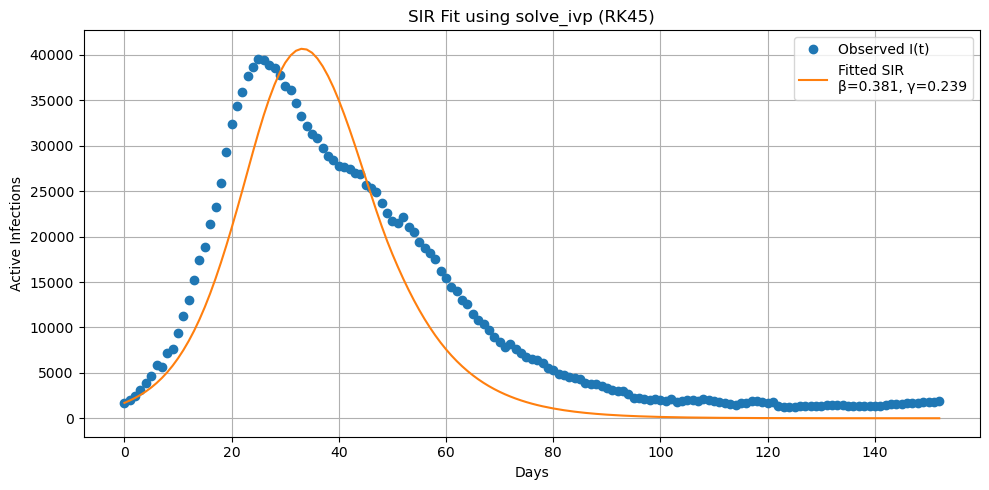

SSE RK4 (full data): 3454869899.6337137
SSE RK4 (second half): 413975875.31108224


In [6]:
# Using scipy's solve_ivp (RK45) to fit beta and gamma for the SIR model

import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

t_obs = np.arange(len(I_obs))

# Initial conditions
S0 = S_obs[0]
I0 = I_obs[0]
R0 = R_obs[0]

# Total population
N = 500000


# --------------------------------------------------
# 1. Correct SIR ODE (must be f(t, y, beta, gamma))
# --------------------------------------------------
def SIR_ode(t, y, beta, gamma):
    S, I, R = y
    dSdt = -(beta/N) * S * I
    dIdt = (beta/N) * S * I - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]


# --------------------------------------------------
# 2. Simulate once (just to test)
# --------------------------------------------------
t_eval = np.arange(0, 161, 1)

sol = solve_ivp(
    lambda t, y: SIR_ode(t, y, 0.3, 0.2),
    [0, 160],
    [S0, I0, R0],
    t_eval=t_eval,
    method="RK45"
)

S_sim = sol.y[0]
I_sim = sol.y[1]
R_sim = sol.y[2]

plt.figure(figsize=(10,5))
plt.plot(sol.t, S_sim, label="S(t)")
plt.plot(sol.t, I_sim, label="I(t)")
plt.plot(sol.t, R_sim, label="R(t)")
plt.xlabel("Days")
plt.ylabel("People")
plt.title("SIR Model Using solve_ivp (RK45)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# --------------------------------------------------
# 3. Function to simulate SIR with given beta, gamma
# --------------------------------------------------
def run_sir(beta, gamma):
    sol = solve_ivp(
        lambda t, y: SIR_ode(t, y, beta, gamma),
        [t_obs[0], t_obs[-1]],
        [S0, I0, R0],
        t_eval=t_obs,
        method="RK45"
    )
    return sol.y[1]   # return I(t)


# --------------------------------------------------
# 4. Objective function (fit to I_obs)
# --------------------------------------------------
def objective(params):
    beta, gamma = params
    I_pred = run_sir(beta, gamma)
    return np.sum((I_pred - I_obs)**2)


# --------------------------------------------------
# 5. Fit β and γ
# --------------------------------------------------
initial_guess = [0.3, 0.2]
bounds = [(0.0001, 2.0), (0.0001, 2.0)]

result = minimize(
    objective,
    initial_guess,
    bounds=bounds,
    method='L-BFGS-B'
)

beta_fit, gamma_fit = result.x
print("β_fit =", beta_fit)
print("γ_fit =", gamma_fit)


# --------------------------------------------------
# 6. Plot fitted vs observed
# --------------------------------------------------
I_fit = run_sir(beta_fit, gamma_fit)

plt.figure(figsize=(10,5))
plt.plot(t_obs, I_obs, 'o', label="Observed I(t)")
plt.plot(t_obs, I_fit, '-', label=f"Fitted SIR\nβ={beta_fit:.3f}, γ={gamma_fit:.3f}")
plt.xlabel("Days")
plt.ylabel("Active Infections")
plt.title("SIR Fit using solve_ivp (RK45)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Re-run RK4 model over full time range ---
sol_RK4 = solve_ivp(
    lambda t, y: SIR_ode(t, y, beta_fit, gamma_fit),
    [t_obs[0], t_obs[-1]],
    [S0, I0, R0],
    t_eval=t_obs,
    method="RK45"
)

I_pred_full = sol_RK4.y[1]

# --- FULL DATA SSE ---
SSE_full = np.sum((I_pred_full - I_obs)**2)
print("SSE RK4 (full data):", SSE_full)

# --- SECOND HALF SSE ---
mid = len(I_obs) // 2

I_pred_second_half = I_pred_full[mid:]
I_obs_second_half  = I_obs[mid:]

SSE_second_half = np.sum((I_pred_second_half - I_obs_second_half)**2)
print("SSE RK4 (second half):", SSE_second_half)




Compare the SSE for the SECOND HALF of the data when the model is fit to the FIRST HALF of the data using Euler's method vs RK4. Did RK4 do a better job?  Why or why not?

The RK4 method did a better job, indicated by a lower SSE value. This is because RK4 is a fourth-order method while Euler's is a first order method. This results in a smaller error as RK4 evaluates the slope at several points inside each step size, reducing lower-order errors.

In [7]:
# SSE comparison between Euler's method and RK4 (solve_ivp) on the SECOND HALF of the data.
if (SSE_second_half<sse_out):
    print("RK4 estimation produces a lower out-of-sample SSE for the second half of the data.")
else:
    print("Euler's estimation produces a lower out-of-sample SSE for the second half of the data.")

RK4 estimation produces a lower out-of-sample SSE for the second half of the data.


#### 4. Improving model fit by overcoming model limitations

Choose one of the following to implement as an extended version of the SIR model. Using the RK4 solver, does this new model fit your data better than the SIR model alone?

<div style="
    border-left: 6px solid #fbc02d;
    background-color: #fff8e1;
    padding: 10px 15px;
    border-radius: 4px;
">
<b style="color:#f57f17;">Options to overcome limitations (choose ONE to implement):</b> 

<ol>
<li> Include births in the model as described in reading.</li> 
<li>Include deaths in the model as described in reading.</li>
<li>Include an exposed compartment (SEIR model). </li>
<li>Include loss of immunity (i.e. R population can go back to S population).</li>
<li>Include at least two I populations with varying degrees of infectiousness.</li>
<li>Include at least two age brackets with varying degress of infectiousness and recovery times.</li>

</ol>

Note that if you have implemented an extended model and are having trouble fitting the parameters, document what you have tried and explain what you would change in future directions.
</div>



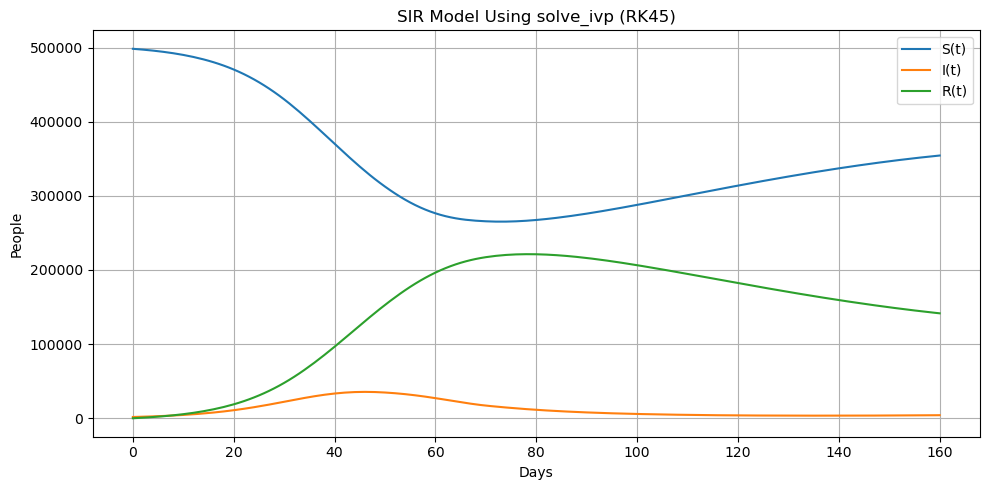

β_fit = 0.4109506795382586
γ_fit = 0.2616250992832705
ω (fixed) = 0.010951403148528405


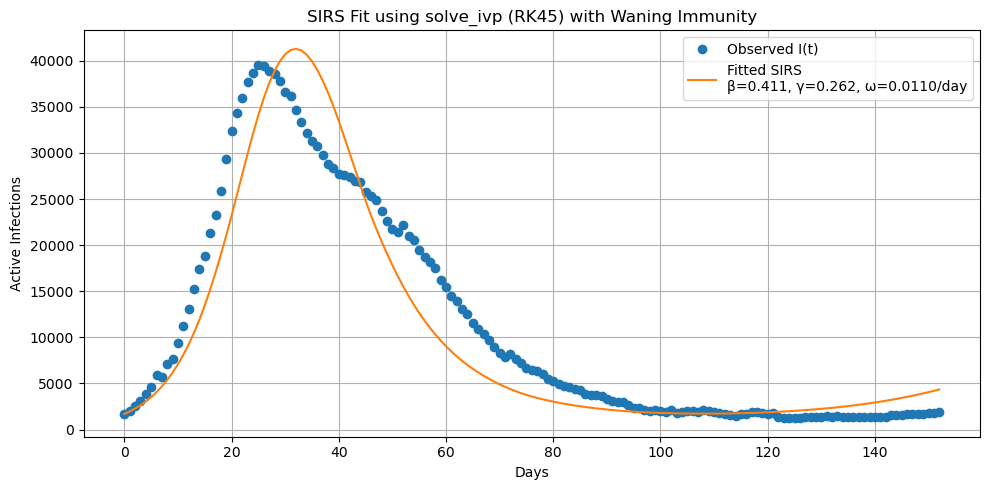

SSE RK4 (full data): 3941981423.7337303
SSE RK4 (second half): 473258281.0785494


In [ ]:
# --------------Extended model implementation, parameter fitting, and plotting.----------------#
# this new code extends the previous SIR model to a SIRS model by adding waning immunity (omega parameter).
# Using scipy's solve_ivp (RK45) to fit beta and gamma for the SIR model

import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt


t_obs = np.arange(len(I_obs))

# Initial conditions
S0 = S_obs[0]
I0 = I_obs[0]
R0 = R_obs[0]

# Total population
N = 500000


# --------------------------------------------------
# 1. Correct SIR ODE (must be f(t, y, beta, gamma))
# --------------------------------------------------
# add omega
days_per_month = 30.4375  # more precise average month length
omega = 1.0 / (3.0 * days_per_month)  # per day

def SIRS_ode(t, y, beta, gamma, omega):
    S, I, R = y
    dSdt = -(beta/N) * S * I + omega * R
    dIdt = (beta/N) * S * I - gamma * I
    dRdt = gamma * I - omega * R
    return [dSdt, dIdt, dRdt]



# --------------------------------------------------
# 2. Simulate once (just to test)
# --------------------------------------------------
t_eval = np.arange(0, 161, 1)

sol = solve_ivp(
    lambda t, y: SIRS_ode(t, y, 0.3, 0.2, omega),
    [0, 160],
    [S0, I0, R0],
    t_eval=t_eval,
    method="RK45"
)

S_sim = sol.y[0]
I_sim = sol.y[1]
R_sim = sol.y[2]

plt.figure(figsize=(10,5))
plt.plot(sol.t, S_sim, label="S(t)")
plt.plot(sol.t, I_sim, label="I(t)")
plt.plot(sol.t, R_sim, label="R(t)")
plt.xlabel("Days")
plt.ylabel("People")
plt.title("SIR Model Using solve_ivp (RK45)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# --------------------------------------------------
# 3. Function to simulate SIR with given beta, gamma
# --------------------------------------------------
def run_sir(beta, gamma, omega=omega):
    sol = solve_ivp(
        lambda t, y: SIRS_ode(t, y, beta, gamma, omega),
        [t_obs[0], t_obs[-1]],
        [S0, I0, R0],
        t_eval=t_obs,
        method="RK45"
    )
    return sol.y[1]   # return I(t)


# --------------------------------------------------
# 4. Objective function (fit to I_obs)
# --------------------------------------------------
def objective(params, omega=omega):
    beta, gamma = params
    I_pred = run_sir(beta, gamma, omega)
    return np.sum((I_pred - I_obs)**2)


# --------------------------------------------------
# 5. Fit β and γ
# --------------------------------------------------
initial_guess = [0.3, 0.2]
bounds = [(0.0001, 2.0), (0.0001, 2.0)]

result = minimize(
    objective,
    initial_guess,
    bounds=bounds,
    method='L-BFGS-B'
)

beta_fit, gamma_fit = result.x
print("β_fit =", beta_fit)
print("γ_fit =", gamma_fit)
print("ω (fixed) =", omega)



# --------------------------------------------------
# 6. Plot fitted vs observed
# --------------------------------------------------
I_fit = run_sir(beta_fit, gamma_fit, omega)

plt.figure(figsize=(10,5))
plt.plot(t_obs, I_obs, 'o', label="Observed I(t)")
plt.plot(t_obs, I_fit, '-', label=f"Fitted SIRS\nβ={beta_fit:.3f}, γ={gamma_fit:.3f}, ω={omega:.4f}/day")
plt.xlabel("Days")
plt.ylabel("Active Infections")
plt.title("SIRS Fit using solve_ivp (RK45) with Waning Immunity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Re-run RK4 model over full time range ---
sol_RK4 = solve_ivp(
    lambda t, y: SIR_ode(t, y, beta_fit, gamma_fit),
    [t_obs[0], t_obs[-1]],
    [S0, I0, R0],
    t_eval=t_obs,
    method="RK45"
)

I_pred_full = sol_RK4.y[1]

# --- FULL DATA SSE ---
SSE_full = np.sum((I_pred_full - I_obs)**2)
print("SSE RK4 (full data):", SSE_full)

# --- SECOND HALF SSE ---
mid = len(I_obs) // 2

I_pred_second_half = I_pred_full[mid:]
I_obs_second_half  = I_obs[mid:]

SSE_second_half = np.sum((I_pred_second_half - I_obs_second_half)**2)
print("SSE RK4 (second half):", SSE_second_half) 

In [10]:
# compare SSE values between the SIR and SIRS models using second half SSE (which predicted better?)
if SSE_second_half < 413975875.31108224:
    print("the SIRS model with waning immunity produces a lower out-of-sample SSE for the second half of the data.")
else:
    print("the orginal SIR model produces a lower out-of-sample SSE for the second half of the data.")

the orginal SIR model produces a lower out-of-sample SSE for the second half of the data.


In [ ]:
# compute R squared by comparing the SIRS model SSE value to the SIR model SSE value (both from the second half)
R_squared = 1 - (SSE_second_half / 413975875.31108224)
print("R squared improvement of SIRS over SIR on second half:", R_squared) # this value is negative because there was no improvement; it got worse

# compute RMSE for the SIRS model on the second half
RMSE_second_half = np.sqrt(SSE_second_half / len(I_obs_second_half))
print("RMSE for SIRS model on second half:", RMSE_second_half)

# compute nRMSE for the SIRS model on the second half
nRMSE_second_half = RMSE_second_half / np.max(I_obs_second_half)
print("nRMSE for SIRS model on second half:", nRMSE_second_half)

R squared improvement of SIRS over SIR on second half: -0.1432025615572874
RMSE for SIRS model on second half: 2479.155388953779
nRMSE for SIRS model on second half: 0.38187852571684827


the values from the SIR model were:
SSE RK4 (full data): 3454869899.6337137
SSE RK4 (second half): 413975875.31108224

The values from the SIRS model were:
SSE RK4 (full data): 3941981423.7337303
SSE RK4 (second half): 473258281.0785494

The original SIR model actually produced a lower SSE value when predicting the second half of the data. That means that adding waning immunity made the model less accurate. 

the normalized RMSE for the second half of the data in the SIRS model was 38%, which is considered a poor fit.

## Verify and validate your analysis: 
The answer is believable, since the nRMSE value for the second half of the data was on the correct order of magnitude and relatively close to an acceptable value (30%). Although the SSE was actually greater for the expanded SIRS model, this is a believable result because the waning immunity paramater was a very general number, and probably does not accurately represent waning immunity in Italy during the specific timeframe of data in our dataset. It makes sense that introducing a parameter that doesn't apply specifically to the dataset (even though it does in all COVID data in general) could actually make the model less accurate. The way the ODE was set up to include omega was such that immunity slowly decreases over 30 days. This total length of decay came from a pulished paper, but might not be accurate for the specific time of data collection. In addition, the mechaninisms of immunity loss could ocurr differently, which means that it makes sense that adding omega might make the model worse.

Our analysis is supported by the statement "Even with these simple models, however, the parameters obtained from our fits can vary significantly for a given location". Additionally, "These models have several sources of uncertainty, including parameter uncertainty, variation based on data or model type used, and most importantly, uncertainty in the severity and length of social distancing measures, which can change the peak date by months or even create multiple peaks. This variability in outcomes highlights the challenges of modeling and forecasting the course of a pandemic during its early stages and with only limited data." The high level of uncertainty in these simple models as described by this paper validates our analysis of the data. It would be unlikely for our models to have low SSE values given the complexity of COVID modeling, the parameters involved in this socially relevant situation, and the simplicity of the model. Adding the extra omega parameter had the potential to improve the model by better representing the actual scenario. But the ODE setup must not acurrately reflect reality because it made the model worse. This concept is reflected in papers that analyze COVID modeling, since each parameter alteration in an SIR style model can drastically change the results. That is why it is so difficult to model COVID, since there are many parameters that need to be inputted correctly, as well adjusted over the course of the model timeframe, since many parameters are constantly shifting.
https://www.pnas.org/doi/10.1073/pnas.2006520117

## Conclusions and Ethical Implications: 
In this project, we used an SIR framework to model COVID-19 dynamics based on a dataset from Italy in 2020 with an adjusted population. We evaluated both numerical methods and model structure by comparing Euler's method and a fourth-order Runge-Kutta solver (RK4) as well as an SIRS model incorporating waning immunity. The performance of the model was assessed using out-of-sample error metrics including SSE, RMSE, normalized RMSE, and R^2 on the second half of the data set. RK4 produced a lower SSE value than Euler's method when evaluated on the second half of the data set, which is expected due to its higher order. The SIRS model produced a higher SSE in the out-of-sample and full dataset, indicating the SIR model as the better fit despite the added parameter of waning immunity. This highlights the importance of selecting appropriate numerical methods and modeling in creating a reliable model. In the context of COVID-19 where parameters vary greatly with location and time period, simple models may be more effective and outperform complex models with overgeneralized assumptions. This exemplifies the broader challenge of balancing numerical methods, the sophistication of modeling, and real-world conditions.

Some ethical implications of using these models to approximate real-world pandemic trends surround the possibility of their inaccuracy. Models in countries with less reporting resources may not accurately reflect the state of the pandemic and could lead to dangerous assumptions that influence personal and public health decisions such as in the case of COVID-19, isolation and mask policies. Additionally, unreliable modeling may cause unnecessary financial harm to businesses or individuals, loss of life due to underestimation of the disease spread, or unnecessary isolation. Models may not accurately reflect the impact of disease on underrepresented groups or could demand private health information of individuals to be accurate, raising a privacy concern. Ethical concerns of modeling predominantly stem from the balance of urgency and uncertainty in modeling infectious diseases: while models are essential in guiding public and personal health decisions, they must be created and presented in a way that upholds transparency and understanding of societal consequences.

## Limitations and Future Work: 
Both the SIR and SIRS model assume homogeneous mixing of the population and disregard factors like age, contact patterns, mobility, or risk exposure. Additionally, transmission rates are assumed constant, despite seasonal changes, policy-driven behavioral changes, and viral evolution. The quality of the dataset may also be a limitation as asymptomatic carriers, reporting delays, and lack of testing availability could all impact the data and therefore the model. Use of generalized parameters such as the assumed waning immunity in the SIRS model and an infectious period of 7 days in both models could also contribute to model inaccuracy. Finally, we used a rescaled population of 500,000 to improve the visibility of the model which could impact the accuracy of modeling due to the difference in magnitude from the actual population. 

Future work could include incorporating time-varying parameters such as transmission and recovery rates, using a more specific waning immunity value for Italy in 2020 to improve the SIRS model, and implementation of a Bayesian methods to estimate uncertainty and better fit parameters.

## NOTES FROM YOUR TEAM: 
* Both partners were absent from class on Tuesday. Maggie came on Thursday and did the dataset background. Worked separately on the digital notebook and emailed to establish a line of communication and a GitHub repository. 
* week 2, part 1: Maggie filled in section 2 and the optimizing from section 1. Gabby did the base code and most of section 1. Maggie filled in dataset background during class on Tuesday.
* final check-in: Gabby filled in section 3 and submitted for the check-in after class work together.
* final notebook: Maggie completed section 4, the model expansion, and wrote the verification and validation. Gabby completed conclusions and ethical implications and limitations and future work and submitted the final notebook.

## QUESTIONS FOR YOUR TA: 
None at this time!